<a href="https://colab.research.google.com/github/nachitog83/mentoria_img/blob/master/5_Aprendizaje_NO_Supervisado/7_Aprendizaje_NO_Supervisado_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación </h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
<h2>Mentoría: Detección de objetos en imágenes</h2>
</center>


En la siguiente notebook, incorporaremos parte de lo realizado en las entregas 1 de los grupos de estudiantes: 

* [Grupo 1](https://github.com/Ana1890/Deteccion-de-objetos-en-imagenes) : Ana Rusconi, Ignacio Grosso y  Mariano Lucero

* [Grupo 2](https://github.com/leorodriguez/mentoria-diplodatos-grupo2):  Diego Gonzalez, Florencia Caballero, Joel Vivas y Leonardo Rodriguez


#### <a name="generacion_tabla"></a>
#### **Análisis general del dataset**

Así como la entrega anterior, en esta entrega utilizaremos el dataset completo, con la tabla generada en 

[5-Generación_de_fotos_recortadas_y_tabla-Aprendizaje_Supervisado](https://colab.research.google.com/drive/1fgB4F4DlBqkCvOatqo3whm4ZTPsiP0L7?usp=sharing)'

La carpeta con los datos, es compartida en el [Drive](https://drive.google.com/drive/folders/1-bl3h1g1WROMmz66A2h7t2n3leTjhYxH?usp=sharing) y en el desarrollo de esta entrega con las consignas, se utilizará la misma en el entorno de Colab, pero también estarán en el repositorio de Github de la mentoría, en la carpeta del práctico de [Aprendizaje Supervisado](https://github.com/luciabarg/mentoria_img/tree/master/4-Aprendizaje%20Supervisado).

La siguiente notebook usa como entorno Colab.

In [2]:
#vinculamos el Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# librerías necesarias 
import os
from IPython.display import Image as Imge
import pandas as pd
import numpy as np
import glob

#seguimos agregando librerías necesarias:
#las que no tengan, vayan instalándolas
import cv2
import numpy as np

import matplotlib.pyplot as plt
import PIL
from PIL import Image
from os import path

from google.colab.patches import cv2_imshow #en Colab!

import seaborn as sns

import re

import json


from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


Para que se hagan una idea de la cantidad de datos que deberíamos analizar, los exploramos y visualizamos con una tabla:

In [4]:
#nos posicionamos en la carpeta con los datos
os.chdir('/content/drive/My Drive/DiploDatos2020/Mentoria/crop')
#listamos solo las carpetas
! ls -d */
! ls -d */*/

Amarillos/  Mano-Amarillo/  Manos/  Mano-Verde/  Verdes/
Mano-Amarillo/Amarillo/  Mano-Verde/Mano/
Mano-Amarillo/Mano/	 Mano-Verde/Verde/


#### <a name="preparation_data"></a>
#### **Lectura de los datos**

In [20]:
#leemos el archivo de la tabla:
csv_wlabels_df = pd.read_csv('csv_wlabels_all_df.csv', index_col=0)
csv_wlabels_df = csv_wlabels_df.drop(['Type'], axis=1)  #la eliminamos ya que es una división previa de los datos, que no utilizaremos en este caso.
print(csv_wlabels_df.shape)
csv_wlabels_df.head()

(15197, 2060)


,filename,xmin,xmax,ymin,ymax,Time,Size,Hand_Pixel_Width,Hand_Pixel_Height,Area,guantes,color,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,M_G_Mostrando_Amarillos_0_double_box1.jpg,218,461,464,715,M,G,243,251,60993,si,Amarillo,0.740974,1.066019,0.132695,0.224892,0.140456,0.129134,0.201447,1.076733,0.461108,0.299800,0.457940,0.201904,0.569677,0.737381,0.480929,0.200076,0.018410,0.674050,0.028826,0.005310,0.128693,0.592353,0.138541,0.141684,0.363294,0.264674,0.519292,0.292655,...,0.463567,0.091676,0.300955,0.696112,2.409413,0.536980,0.102273,0.157441,0.165093,1.067619,0.751934,0.231443,0.487437,0.446320,0.822407,0.527523,0.217110,0.489194,1.535306,0.521390,0.599480,0.201182,0.391337,0.040206,1.347440,0.448389,0.462778,0.590751,0.877142,0.009986,0.939221,0.859877,0.981910,0.356366,1.748501,0.288037,0.079172,0.266234,0.078312,0.421612
1,M_G_Mostrando_Amarillos_0_double_box2.jpg,617,865,432,598,M,G,248,166,41168,si,Amarillo,1.621832,0.208859,0.627041,0.061717,0.052486,0.064176,0.479256,1.068516,0.509059,0.207385,0.218195,0.169190,0.695486,0.237641,0.146711,0.126334,0.029900,0.148363,0.126833,0.181351,0.044585,0.447270,0.134360,0.113650,1.153900,0.653832,0.041024,0.543086,...,0.816892,0.027489,0.183116,0.626535,1.734605,0.672962,0.030057,0.101685,0.295544,0.392251,0.874054,0.105285,0.110713,0.421417,1.335695,0.500971,1.139208,0.110803,0.850265,0.618181,0.077352,0.376629,0.319234,0.783792,0.427963,0.133063,0.064981,0.017857,0.320706,0.219192,1.199712,0.808466,0.491182,0.356616,0.812572,0.481357,0.071471,0.572322,0.052072,0.213453
2,M_G_Mostrando_Amarillos_100_double_box1.jpg,831,1138,256,408,M,G,307,152,46664,si,Amarillo,1.029100,0.246964,0.825601,0.460009,0.467037,0.339540,0.653041,1.324649,0.890402,0.488183,0.639772,0.085819,0.928661,0.148958,0.066155,0.125391,0.191808,0.506981,0.257565,0.073959,0.115524,0.552251,0.764911,0.047104,0.207601,0.126297,0.286010,0.733891,...,0.367434,0.436251,0.000000,0.863331,0.112969,0.902164,0.040710,0.467132,0.242757,0.853286,0.677067,0.300664,0.587456,0.112658,1.077973,0.144736,0.294853,0.065939,0.708062,1.192815,0.317312,0.421216,0.425882,1.091190,0.595093,0.138662,0.045023,0.543350,0.155850,0.305535,0.463963,0.355296,0.360880,0.322859,0.917611,0.408334,0.733588,0.416891,0.151471,0.045931
3,M_G_Mostrando_Amarillos_100_double_box2.jpg,511,812,8,228,M,G,301,220,66220,si,Amarillo,0.086092,0.455828,0.418580,0.131673,0.437982,0.424093,0.350489,1.974670,0.183887,0.241193,0.046988,0.312450,0.497026,0.135973,0.195146,0.010869,0.109539,0.234128,0.235778,0.108441,0.054660,0.327069,0.439913,0.050670,0.159292,0.159228,0.311495,0.999218,...,0.625021,0.219692,0.029219,0.496582,1.540741,2.338270,0.039844,0.174714,0.383931,0.449525,0.104648,0.205243,0.104140,0.109657,1.092486,0.087052,0.451129,0.034648,0.272219,0.209507,0.138235,0.193764,0.081227,1.006930,1.506502,0.044992,1.047619,0.605296,0.391379,0.164156,0.325708,0.028549,0.225465,0.325055,0.460382,0.127341,0.140412,0.157423,0.296102,0.023314
4,M_G_Mostrando_Amarillos_101_double_box1.jpg,668,988,0,222,M,G,320,222,71040,si,Amarillo,0.068881,0.185060,0.427007,0.637546,0.357156,0.125816,0.450526,1.246901,0.236921,0.393104,0.632759,0.413947,0.119917,0.192305,0.372677,0.075668,0.103642,0.165934,0.239047,0.054987,0.129182,0.178563,0.217686,0.130172,0.080214,0.346873,0.392784,1.042759,...,0.205059,0.225329,0.062677,0.558553,1.780167,1.919532,0.165511,0.649451,0.168220,0.127490,0.310012,0.071468,0.196005,0.042177,1.261848,0.216220,0.501204,0.194764,0.183244,0.426975,0.477355,0.349516,0.131819,0.489718,0.981365,0.049099,0.471963,0.190929,0.413278,0.175050,0.523058,0.028629,0.076427,0.462088,0.694069,0.060703,0.065414,0.296513,0.368063,0.039469


### **Recordar** 
  * Separar los tamaños 'P' y 'G'. Tratarlos como conjuntos de datos por separado. 
  
  * Hacer preprocesamiento: eliminar columnas innecesarias, normalizar o estandarizar las columnas numéricas si fuera necesario, usar encoding para las categóricas y todas las transformaciones que crean necesarias.

##### UTILIZAMOS COMO VARIABLE TARGET LA COLUMNA "GUANTES"



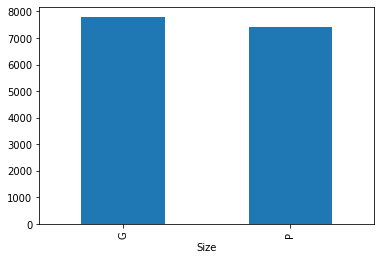

In [21]:
csv_wlabels_df.groupby('Size').filename.count().plot(kind='bar')

In [22]:
perc_P = round(csv_wlabels_df[csv_wlabels_df.Size=='P'].filename.count()/csv_wlabels_df.shape[0]*100, 2)
perc_G = round(csv_wlabels_df[csv_wlabels_df.Size=='G'].filename.count()/csv_wlabels_df.shape[0]*100, 2)
print(f"PORCENTAJE P: {perc_P}%\nPORCENTAJE G: {perc_G}%")

PORCENTAJE P: 48.74%
PORCENTAJE G: 51.26%


Realizaremos encoding de las variables categoricas que se van a utilizar para el analisis; Guantes, Time, Size, y Color

In [23]:
from sklearn.preprocessing import LabelEncoder

In [24]:
le_guantes = LabelEncoder()
le_time = LabelEncoder()
le_size = LabelEncoder()
le_color = LabelEncoder()
csv_wlabels_df.guantes = le_guantes.fit_transform(csv_wlabels_df.guantes)
csv_wlabels_df.Time = le_time.fit_transform(csv_wlabels_df.Time)
csv_wlabels_df.Size = le_size.fit_transform(csv_wlabels_df.Size)
csv_wlabels_df.color = le_color.fit_transform(csv_wlabels_df.color)

In [25]:
csv_wlabels_df.head()

,filename,xmin,xmax,ymin,ymax,Time,Size,Hand_Pixel_Width,Hand_Pixel_Height,Area,guantes,color,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,M_G_Mostrando_Amarillos_0_double_box1.jpg,218,461,464,715,0,0,243,251,60993,1,0,0.740974,1.066019,0.132695,0.224892,0.140456,0.129134,0.201447,1.076733,0.461108,0.299800,0.457940,0.201904,0.569677,0.737381,0.480929,0.200076,0.018410,0.674050,0.028826,0.005310,0.128693,0.592353,0.138541,0.141684,0.363294,0.264674,0.519292,0.292655,...,0.463567,0.091676,0.300955,0.696112,2.409413,0.536980,0.102273,0.157441,0.165093,1.067619,0.751934,0.231443,0.487437,0.446320,0.822407,0.527523,0.217110,0.489194,1.535306,0.521390,0.599480,0.201182,0.391337,0.040206,1.347440,0.448389,0.462778,0.590751,0.877142,0.009986,0.939221,0.859877,0.981910,0.356366,1.748501,0.288037,0.079172,0.266234,0.078312,0.421612
1,M_G_Mostrando_Amarillos_0_double_box2.jpg,617,865,432,598,0,0,248,166,41168,1,0,1.621832,0.208859,0.627041,0.061717,0.052486,0.064176,0.479256,1.068516,0.509059,0.207385,0.218195,0.169190,0.695486,0.237641,0.146711,0.126334,0.029900,0.148363,0.126833,0.181351,0.044585,0.447270,0.134360,0.113650,1.153900,0.653832,0.041024,0.543086,...,0.816892,0.027489,0.183116,0.626535,1.734605,0.672962,0.030057,0.101685,0.295544,0.392251,0.874054,0.105285,0.110713,0.421417,1.335695,0.500971,1.139208,0.110803,0.850265,0.618181,0.077352,0.376629,0.319234,0.783792,0.427963,0.133063,0.064981,0.017857,0.320706,0.219192,1.199712,0.808466,0.491182,0.356616,0.812572,0.481357,0.071471,0.572322,0.052072,0.213453
2,M_G_Mostrando_Amarillos_100_double_box1.jpg,831,1138,256,408,0,0,307,152,46664,1,0,1.029100,0.246964,0.825601,0.460009,0.467037,0.339540,0.653041,1.324649,0.890402,0.488183,0.639772,0.085819,0.928661,0.148958,0.066155,0.125391,0.191808,0.506981,0.257565,0.073959,0.115524,0.552251,0.764911,0.047104,0.207601,0.126297,0.286010,0.733891,...,0.367434,0.436251,0.000000,0.863331,0.112969,0.902164,0.040710,0.467132,0.242757,0.853286,0.677067,0.300664,0.587456,0.112658,1.077973,0.144736,0.294853,0.065939,0.708062,1.192815,0.317312,0.421216,0.425882,1.091190,0.595093,0.138662,0.045023,0.543350,0.155850,0.305535,0.463963,0.355296,0.360880,0.322859,0.917611,0.408334,0.733588,0.416891,0.151471,0.045931
3,M_G_Mostrando_Amarillos_100_double_box2.jpg,511,812,8,228,0,0,301,220,66220,1,0,0.086092,0.455828,0.418580,0.131673,0.437982,0.424093,0.350489,1.974670,0.183887,0.241193,0.046988,0.312450,0.497026,0.135973,0.195146,0.010869,0.109539,0.234128,0.235778,0.108441,0.054660,0.327069,0.439913,0.050670,0.159292,0.159228,0.311495,0.999218,...,0.625021,0.219692,0.029219,0.496582,1.540741,2.338270,0.039844,0.174714,0.383931,0.449525,0.104648,0.205243,0.104140,0.109657,1.092486,0.087052,0.451129,0.034648,0.272219,0.209507,0.138235,0.193764,0.081227,1.006930,1.506502,0.044992,1.047619,0.605296,0.391379,0.164156,0.325708,0.028549,0.225465,0.325055,0.460382,0.127341,0.140412,0.157423,0.296102,0.023314
4,M_G_Mostrando_Amarillos_101_double_box1.jpg,668,988,0,222,0,0,320,222,71040,1,0,0.068881,0.185060,0.427007,0.637546,0.357156,0.125816,0.450526,1.246901,0.236921,0.393104,0.632759,0.413947,0.119917,0.192305,0.372677,0.075668,0.103642,0.165934,0.239047,0.054987,0.129182,0.178563,0.217686,0.130172,0.080214,0.346873,0.392784,1.042759,...,0.205059,0.225329,0.062677,0.558553,1.780167,1.919532,0.165511,0.649451,0.168220,0.127490,0.310012,0.071468,0.196005,0.042177,1.261848,0.216220,0.501204,0.194764,0.183244,0.426975,0.477355,0.349516,0.131819,0.489718,0.981365,0.049099,0.471963,0.190929,0.413278,0.175050,0.523058,0.028629,0.076427,0.462088,0.694069,0.060703,0.065414,0.296513,0.368063,0.039469


In [26]:
X_P = csv_wlabels_df[csv_wlabels_df.Size == 1]
X_G = csv_wlabels_df[csv_wlabels_df.Size == 0]

In [27]:
X_P.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7407 entries, 701 to 15196
Columns: 2060 entries, filename to 2047
dtypes: float64(2048), int64(11), object(1)
memory usage: 116.5+ MB


In [28]:
X_G.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7790 entries, 0 to 14531
Columns: 2060 entries, filename to 2047
dtypes: float64(2048), int64(11), object(1)
memory usage: 122.5+ MB


In [29]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [30]:
y_P = X_P.guantes
X_P = X_P.drop(['guantes', 'filename',	'xmin',	'xmax',	'ymin',	'ymax', 'Size',	'Hand_Pixel_Width',	'Hand_Pixel_Height'], axis=1)
y_G = X_G.guantes
X_G = X_G.drop(['guantes', 'filename',	'xmin',	'xmax',	'ymin',	'ymax', 'Size',	'Hand_Pixel_Width',	'Hand_Pixel_Height'], axis=1)

In [31]:
best_P = SelectKBest(score_func=chi2, k=10)
fitP = best_P.fit(X_P,y_P)
best_G = SelectKBest(score_func=chi2, k=10)
fitG = best_G.fit(X_G,y_G)

In [32]:
colsP = best_P.get_support(indices=True)
colsG = best_G.get_support(indices=True)

In [33]:
X_P.iloc[:,colsP]

,Area,color,164,518,792,1312,1403,1404,1999,2022
701,3570,0,0.172351,0.496787,0.280303,1.707431,2.005965,0.114271,0.252419,0.839936
702,5307,0,0.285534,1.079900,0.451190,0.840009,1.082235,0.138176,0.933585,1.158667
703,3888,0,0.096481,1.237995,0.704170,0.987216,1.229397,0.210465,1.097883,1.179126
704,5220,0,0.263297,0.839983,0.798893,0.619644,1.372161,0.066747,0.835252,0.869703
705,5084,0,0.509069,0.709603,0.544463,0.985081,0.907487,0.376771,0.488091,0.558104
...,...,...,...,...,...,...,...,...,...,...
15192,3780,1,0.061689,0.361344,0.102089,0.016902,0.132663,0.057635,0.177393,0.006509
15193,2440,1,0.051484,0.679448,0.167554,0.141135,0.244863,0.000153,0.271620,0.196210
15194,2850,1,0.266983,0.525683,0.029936,0.160759,0.228929,0.030149,0.114129,0.143220
15195,2544,1,0.422640,0.806632,0.376779,0.108638,0.120443,0.290470,0.042373,0.001511


In [34]:
X_G.iloc[:,colsG]

,Area,color,164,432,481,543,707,1118,1403,1933
0,60993,0,0.204712,1.547572,1.021463,1.541047,2.046458,1.845039,2.091972,1.979691
1,41168,0,0.120290,1.723048,0.249811,1.099731,1.807691,0.401720,2.350013,1.228421
2,46664,0,0.029737,0.136739,0.240438,3.585921,0.415846,0.185582,1.808360,0.592616
3,66220,0,0.096193,1.015877,0.972317,2.157682,1.696834,1.236359,2.062592,1.502371
4,71040,0,0.294152,1.469490,0.943860,0.775225,2.459728,1.286598,1.024729,1.742903
...,...,...,...,...,...,...,...,...,...,...
14527,28304,1,0.216057,1.207222,0.746938,0.247085,1.372186,0.715033,0.017454,2.011424
14528,32400,1,0.239870,0.783577,0.040074,1.735971,0.921431,0.193183,0.464870,0.497839
14529,80647,1,0.407772,3.186525,0.804623,0.048212,2.329365,2.272906,0.154702,1.016053
14530,74504,1,0.060584,0.714485,0.527859,1.131074,0.600707,0.264362,0.773948,0.869109


### Exploratorio Clustering con dos variables: 

Para visualizar clustering de a pares, tomen dos de las columnas que no sean target o string de las columnas 0 a la 12  (prueben otra que no sea 'Área' ;), a ver que sale), con dos de las mas representativas que hayan hallado en las otras entregas (respectivamente para los conjuntos 'P' y 'G'). 

Colorear por clasificación binaria ('guantes') o multiclase ('color').

###  Clústering con Kmeans y Mean Shift

Para *Kmeans*: Probar con varias cantidades de grupos (si, esperamos 2 o 3 según nuestro conjunto de datos, pero por lo general no se tiene esa información). 

Para *Mean Shift*: Estimar con Mean Shift el número de clústers de nuestros datos.

Utilizar los métodos del codo y de siluetas para determinar el número óptimo de clústers. Visualizar un par de columnas para 'P y 'G' como en el punto anterior.

Comparar los números de clúster entre métodos.

Realizar tabla de contingencia.
¿Se corresponden las clases que sabemos que hay, con los clústers que encontraron? 


### Visualizacion con embeddings: tSNE

Revisar las filminas de la [clase](https://docs.google.com/presentation/d/1LopbC1SjTgXkBAxeg8yRkreiKOwE7bu3TbUo9jK4cFQ/present?slide=id.p) a partir de la slide 29. 

Para obtener las columnas a partir de la 13, se eliminó justamente esa última capa de predicción y obtuvimos una caracterización de la imagen, pero, como se indica justamente en las filminas, perdemos interpretabilidad de dichas características. 

Explorar opciones para transformar el espacio de dim 2048 en un espacio de dimensión 2 (n_components=2). 

Chusmear este [link](https://distill.pub/2016/misread-tsne/) recomendado en las filminas para identificar como influyen los parámetros.

En en el espacio *tSNE*, cuántos clústers encuentran con *Kmeans* y *Mean Shift*?

Pueden visualizar las clases que sabemos que existen sobre los clústers? 

### Componentes-Principales 

Computar las componentes principales y elijan *n_components* para quedarnos con una cantidad chica de componentes. 

Visualizar las 2 componentes con mas peso. 

En en el espacio *tSNE*, cuántos clústers encuentran con *Kmeans* y *Mean Shift*?

Pueden visualizar las clases que sabemos que existen sobre los clústers? 


# Self learning 
## Clasificación semisupervisada

Aprovechando que tenemos imágenes, elegir y explorar una imagen *G* de guantes (amarillos y verdes) y de manos. Y entrenar un modelo k-Nearest Neighbor con los pixeles que etiquetaron.

Utilizar dicho modelo para clasificar y realizar mejoras, revisar notebook ['ntb4_self_learning.ipynb'](https://github.com/DiploDatos/AprendizajeNOSupervisado/blob/master/2020/ntb4_self_learning.ipynb) 